In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
label_mapping = {
    'climbing': 0,
    'diving': 1,
    'fishing': 2,
    'racing': 3,
    'throwing': 4,
    'pole vaulting': 5
}

In [3]:
train_dir = './data/train'
test_dir = './data/test'

train_image_paths = []
train_image_labels = []
test_image_paths = []
test_image_labels = []

In [4]:
for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    label = filename.split('_')[0]

    train_image_paths.append(image_path)
    train_image_labels.append(label_mapping[label])

In [5]:
for filename in os.listdir(test_dir):
    image_path = os.path.join(test_dir, filename)
    label = filename.split('_')[0]

    test_image_paths.append(image_path)
    test_image_labels.append(label_mapping[label])

In [6]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
])

In [7]:
class BARImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.image_labels[idx]
        return image, label

In [8]:
train_dataset = BARImageDataset(train_image_paths, train_image_labels, transformer)
test_dataset = BARImageDataset(test_image_paths, test_image_labels, transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

In [10]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [11]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=[2, 3])

        weights = weights[:, :, None, None]

        heatmap = torch.sum(weights * self.activations, dim=1).squeeze()

        heatmap = F.relu(heatmap)
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        return heatmap.cpu().detach().numpy()


In [12]:
def overlay_heatmap(heatmap, image_path, alpha=0.5):
    original_image = Image.open(image_path).convert("RGB")

    heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(original_image.size, Image.BILINEAR)

    heatmap_colored = plt.cm.jet(np.array(heatmap_resized) / 255.0)[:, :, :3] * 255
    heatmap_colored = Image.fromarray(np.uint8(heatmap_colored))

    overlayed_image = Image.blend(original_image, heatmap_colored, alpha=alpha)
    return overlayed_image

In [13]:
def generate_and_visualize_heatmap(image_path, model, target_layer_name, class_idx=None):
    model.eval()

    transformer = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transformer(image).unsqueeze(0).to(device)

    grad_cam = GradCAM(model, target_layer_name)

    outputs = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(outputs, dim=1).item()

    model.zero_grad()
    outputs[0, class_idx].backward()

    heatmap = grad_cam.generate_heatmap(class_idx)

    overlayed_image = overlay_heatmap(heatmap, image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Heat Map Overlay")
    plt.imshow(overlayed_image)
    plt.axis("off")
    plt.show()

In [14]:
model = ResNet18(num_classes=6)

optimizer = optim.SGD(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/100
Loss: 1.5198, Accuracy: 41.58%
Epoch 2/100
Loss: 1.1800, Accuracy: 60.69%
Epoch 3/100
Loss: 1.0178, Accuracy: 69.09%
Epoch 4/100
Loss: 0.8719, Accuracy: 73.06%
Epoch 5/100
Loss: 0.7427, Accuracy: 77.85%
Epoch 6/100
Loss: 0.6462, Accuracy: 79.03%
Epoch 7/100
Loss: 0.5731, Accuracy: 82.23%
Epoch 8/100
Loss: 0.5385, Accuracy: 83.10%
Epoch 9/100
Loss: 0.4989, Accuracy: 84.03%
Epoch 10/100
Loss: 0.4713, Accuracy: 84.34%
Epoch 11/100
Loss: 0.4281, Accuracy: 86.91%
Epoch 12/100
Loss: 0.4142, Accuracy: 86.55%
Epoch 13/100
Loss: 0.3884, Accuracy: 87.43%
Epoch 14/100
Loss: 0.3824, Accuracy: 87.48%
Epoch 15/100
Loss: 0.3485, Accuracy: 89.23%
Epoch 16/100
Loss: 0.3552, Accuracy: 88.25%
Epoch 17/100
Loss: 0.3266, Accuracy: 89.64%
Epoch 18/100
Loss: 0.3009, Accuracy: 90.67%
Epoch 19/100
Loss: 0.3120, Accuracy: 89.85%
Epoch 20/100
Loss: 0.2718, Accuracy: 91.76%
Epoch 21/100
Loss: 0.2761, Accuracy: 90.93%
Epoch 22/100
Loss: 0.2617, Accuracy: 92.58%
Epoch 23/100
Loss: 0.2396, Accuracy: 92.5

Loss = `[1.5198, 1.18, 1.0178, 0.8719, 0.7427, 0.6462, 0.5731, 0.5385, 0.4989, 0.4713, 0.4281, 0.4142, 0.3884, 0.3824, 0.3485, 0.3552, 0.3266, 0.3009, 0.312, 0.2718, 0.2761, 0.2617, 0.2396, 0.2391, 0.2044, 0.2007, 0.19, 0.1754, 0.1677, 0.1676, 0.1593, 0.1519, 0.1281, 0.1307, 0.1241, 0.1111, 0.1074, 0.1073, 0.1167, 0.0952, 0.0992, 0.0869, 0.0854, 0.0763, 0.0626, 0.0701, 0.0646, 0.0659, 0.0603, 0.055, 0.077, 0.0589, 0.0532, 0.0453, 0.0369, 0.0348, 0.0344, 0.0413, 0.0299, 0.0323, 0.0255, 0.0295, 0.0281, 0.0292, 0.023, 0.0194, 0.0179, 0.0218, 0.0177, 0.0203, 0.0195, 0.0189, 0.0143, 0.0223, 0.0173, 0.0199, 0.0154, 0.0149, 0.0133, 0.0134, 0.0124, 0.0104, 0.0129, 0.0087, 0.0251, 0.0216, 0.0309, 0.0149, 0.0143, 0.0207, 0.0109, 0.0104, 0.0106, 0.0092, 0.0082, 0.0078, 0.0103, 0.0096, 0.0077, 0.0124]`

In [17]:
model.eval()

test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss = test_running_loss / len(test_loader)
test_acc = 100 * test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 3.6024, Test Accuracy: 27.06%


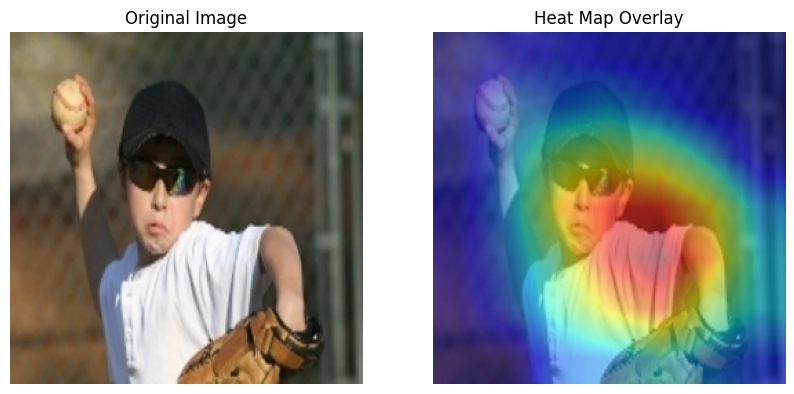

In [19]:
image_path = './data/test/throwing_321.jpg'
target_layer_name = 'layer4'
generate_and_visualize_heatmap(image_path, model, target_layer_name)